Images, WCS, and Overlays
=========================

Also might get to subplots in this section, just because we can. But we're going to go plaid speed so buckle up.

In [1]:
import numpy as np
import datetime as dt
import astropy.io.fits as pyf

infile = "./m51_pacs.fits"

In [2]:
hdus = pyf.open(infile)
print("%d header data units found" % (len(hdus)))
print(hdus)

8 header data units found
[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x15165544a8>, <astropy.io.fits.hdu.image.ImageHDU object at 0x15165647b8>, <astropy.io.fits.hdu.image.ImageHDU object at 0x151656cc18>, <astropy.io.fits.hdu.image.ImageHDU object at 0x15165749b0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x1516579a58>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x1516582668>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x1516ce4470>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x1516ce8c88>]


This is a complicated file, as you can see.  In the list of header units we can see:

1 "PrimaryHDU" object (usually 0-dimensional, descriptive only)

4 "ImageHDU" objects (images)

3 "BinTableHDU" objects (FITS binary tables)

Since I know this is a PACS image, the header is quite nice to look at so lets take a gander at the first HDU.

In [3]:
hdus[0].header

SIMPLE  =                    T / Java FITS: Thu Feb 18 18:24:43 CET 2016        
BITPIX  =                   32                                                  
NAXIS   =                    0 / Dimensionality                                 
EXTEND  =                    T / May contain datasets                           
TIMESYS = 'UTC     '           / All dates are in UTC time                      
LONGSTRN= 'OGIP 1.0'           / The OGIP long string convention may be used.   
COMMENT This FITS file may contain long string keyword values that are          
COMMENT continued over multiple keywords.  This convention uses the  '&'        
COMMENT character at the end of a string which is then continued                
COMMENT on subsequent keywords whose name = 'CONTINUE'.                         
          ---------------Herschel FITS Data Generator---------------            
          This product is generated by Herschel software.                       
HCSS____=                   

In [4]:
# Getting the Herschel HDU descriptions from each HDU in our image
[each.header['INFO____'] for each in hdus]

['Photometry red JScanam map',
 'Image',
 'Coverage',
 'Mean flux standard Deviation',
 'History of product',
 'History as Jython script',
 'History of tasks',
 'The parameters belonging to the task history']

In [5]:
bandpass = hdus[0].header['WAVELNTH']
objname = hdus[0].header['OBJECT']

# Since hdus[1] is the actual image, it'll have the WCS and flux information
# hdus[2] will be a segmentation-like map (indicating the areas well covered)
# hdus[3] will be the error map
# we don't care about anything else past that
units = hdus[1].header['BUNIT']
epoch = hdus[1].header['EQUINOX']

# Note that we can also just get this by reading the shape of hdu[1]
naxis = (hdus[1].header['NAXIS1'], hdus[1].header['NAXIS2'])
print("NAXIS1,2: ", naxis)
print("np.shape: ", np.shape(hdus[1].data))

NAXIS1,2:  (458, 462)
np.shape:  (462, 458)


In [6]:
imgdat = hdus[1].data
errdat = hdus[3].data

Image Plotting
==============

In [7]:
import matplotlib.pyplot as plt

plt.imshow(imgdat)
plt.show()
plt.close()

<Figure size 640x480 with 1 Axes>

Notice how 0,0 is on the upper left?  No bueno.  Lets fix that.

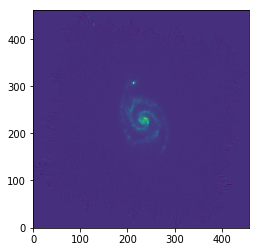

In [8]:
plt.imshow(imgdat, origin='lower')
plt.show()
plt.close()

Let's be slightly more fancy and start playing with the plotting objects.

See also http://docs.astropy.org/en/stable/visualization/wcsaxes

This page will become your best friend too http://docs.astropy.org/en/stable/visualization/wcsaxes/ticks_labels_grid.html

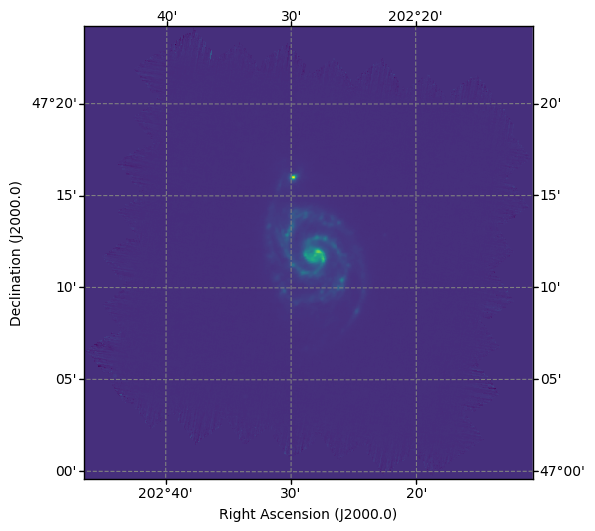

In [9]:
from astropy.wcs import WCS

# Remember that we found the WCS info in hdus[1], NOT hdus[0]
wcs = WCS(hdus[1].header)

fig = plt.figure(figsize=(6, 6), dpi=100)
ax = plt.subplot(projection=wcs)
ax.imshow(imgdat, origin='lower')

overlay = ax.get_coords_overlay('fk5')
overlay.grid(color='grey', ls='dashed')
ax.set_xlabel('Right Ascension (J%s)' % (epoch))
ax.set_ylabel('Declination (J%s)' % (epoch))

plt.show()
plt.close()

Looking pretty good so far; now what can we do about this color scaling and color scheme?

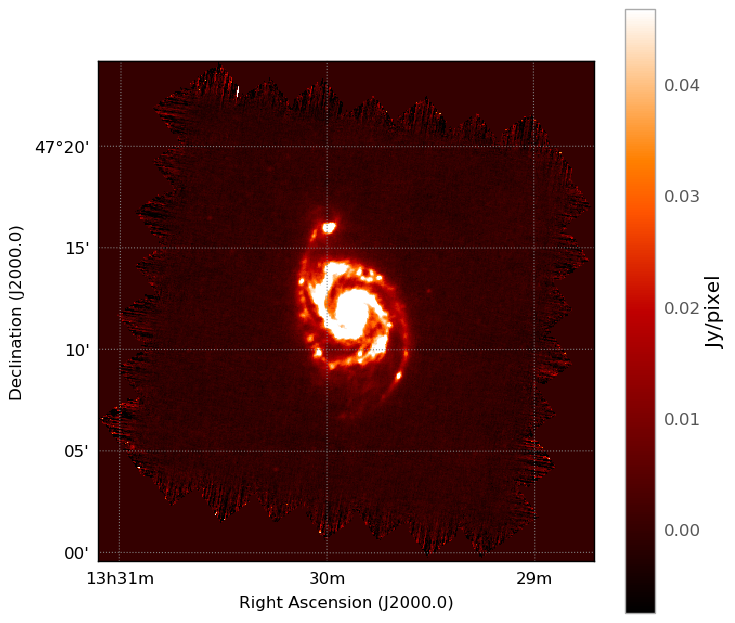

In [10]:
from astropy.wcs import WCS
from astropy.visualization import astropy_mpl_style
from astropy.visualization import PercentileInterval, ImageNormalize

# Basically pure magic
plt.style.use(astropy_mpl_style)

# Remember that we found the WCS info in hdus[1], NOT hdus[0]
wcs = WCS(hdus[1].header)

fig = plt.figure(figsize=(8, 8), dpi=100)
ax = plt.subplot(projection=wcs)

# Read the docs! This only works for equitorial and galactic (glat/glon)
ra = ax.coords['ra']
dec = ax.coords['dec']

# Now that we have the objects, we can easily do stuff with them
#   How did I figure these out? By reading the docs!
# http://docs.astropy.org/en/stable/visualization/wcsaxes/ticks_labels_grid.html
ra.set_axislabel('Right Ascension (J%s)' % (epoch))
dec.set_axislabel('Declination (J%s)' % (epoch))
ra.grid(color='grey', linestyle='dotted')
dec.grid(color='grey', linestyle='dotted')
ra.set_major_formatter('hh:mm')
dec.set_major_formatter('dd:mm')

# Set up our image display stuff
norm = ImageNormalize(imgdat, interval=PercentileInterval(98.))

im = ax.imshow(imgdat, origin='lower', norm=norm)
cbar = fig.colorbar(im, pad=0.05, orientation='vertical')
cbar.set_label("%s" % (units))

plt.show()
plt.close()

Notice that when we used the astropy style, all the annoying stuff (ticks pointing outwards) went away?  Matplotlib has made a number of design choices that grind astronomers' gears and that's the easy way to start from a cleaner slate.

The one real wildcard was the introduction of ```plt.subplot()``` rather than ```plt.axes()```.  The former sets up a grid of plotting opportunities, and returns the axes object needed to reference the first one.  It gives more bells and whistles which is why astropy has shoved their WCS extensions into ```plt.subplot()``` rather than shoehorn it into the base ```plt.axes()``` class.  I think.

What if we wanted to exclude the crusty scan artifacted edges? We can do that either in RA/Dec space or in pixel space. Doesn't really matter but for this kind of stuff, pixel space is usually way easier.

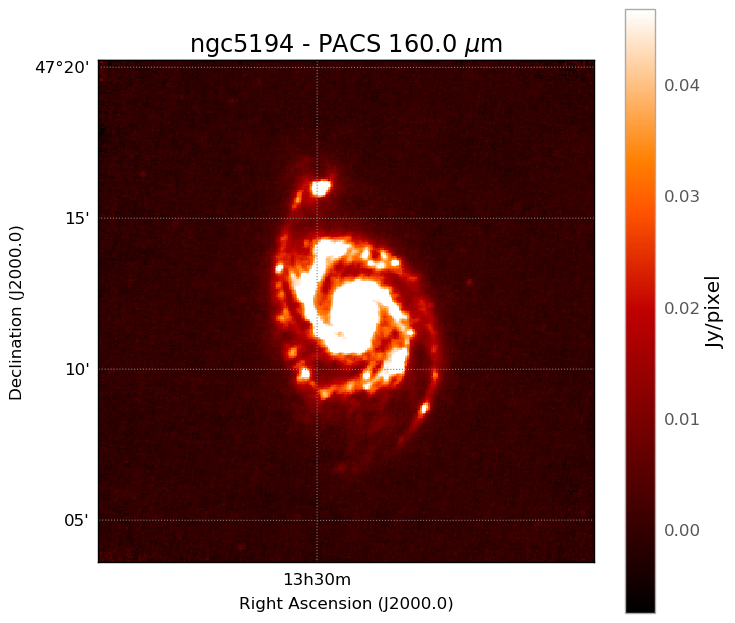

In [11]:
from astropy.wcs import WCS
from astropy.visualization import astropy_mpl_style
from astropy.visualization import PercentileInterval, ImageNormalize

# Basically pure magic
plt.style.use(astropy_mpl_style)

# Remember that we found the WCS info in hdus[1], NOT hdus[0]
wcs = WCS(hdus[1].header)

fig = plt.figure(figsize=(8, 8), dpi=100)
ax = plt.subplot(projection=wcs)

# Read the docs! This only works for equitorial and galactic (glat/glon)
ra = ax.coords['ra']
dec = ax.coords['dec']

# Now that we have the objects, we can easily do stuff with them
#   How did I figure these out? By reading the docs!
# http://docs.astropy.org/en/stable/visualization/wcsaxes/ticks_labels_grid.html
ra.set_axislabel('Right Ascension (J%s)' % (epoch))
dec.set_axislabel('Declination (J%s)' % (epoch))
ra.grid(color='grey', linestyle='dotted')
dec.grid(color='grey', linestyle='dotted')
ra.set_major_formatter('hh:mm')
dec.set_major_formatter('dd:mm')

# Set up our image display stuff
norm = ImageNormalize(imgdat, interval=PercentileInterval(98.))

im = ax.imshow(imgdat, origin='lower', norm=norm)
cbar = fig.colorbar(im, pad=0.05, orientation='vertical')
cbar.set_label("%s" % (units))

# Adjust our plot extents (in pixels)
#   Adjusting the plot extent in actual coordinates is left as 
#   an exercise for the listener
ax.set_xlim(75, imgdat.data.shape[1] - 75)
ax.set_ylim(75, imgdat.data.shape[0] - 75)

plt.title("%s - PACS %s $\mu $m" % (objname, bandpass))
plt.show()
plt.close()

For images, if you want to get much fancier than this, it's best to start looking at Aplpy.  It has Montage integration, as well as tons of little nicities that will make your life much easier:

- Trivial addition of beam size
- Easy addition of scale bars
- Easy addition of a compass rose
- Better arbitrary projections and axes and transformations

It's an Astropy affiliated package so it's high quality...the downside is that worked examples are pretty spare in the documentation.

https://aplpy.github.io/